In [1]:
#==================================================================
#Program: DEVEL_2
#Version: 1.0
#Author: David Helminiak
#Date Created: September 3, 2024
#Date Last Modified: September 16, 2024
#Description: Re-implementation of a unified block classifier code for breast cancer data
#Operation: Move back into main program directory before running.
#Status: Deprecated - Isolated inconsistencies with pre-processing of available data; moved to DEVEL_3
#==================================================================

#Have the notebook fill more of the display width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:80% !important; }</style>"))

#Items otherwise covered when not running this code in a notebook
import tempfile
dir_tmp = tempfile.TemporaryDirectory(prefix='TMP_').name
configFileName = './CONFIG_0-TEST'

In [3]:
#==================================================================
#CONFIG PARAMETERS
#==================================================================

#TASKS
#==================================================================
#Should classification of blocks and their originating WSI be performed
classifierBlocks = True

#Should classifier model components be saved/exported
classifierExport = True

#Should WSI be segmented into blocks and classified; generates data needed for RANDS
classifierWSI = True
#==================================================================

#CLASSIFICATION - BLOCKS
#==================================================================
#Should features be extracted for blocks and overwrite previously generated files
overwrite_blocks_features = True

#Should saliency maps be determined for blocks and overwrite previously generated files
overwrite_blocks_saliencyMaps = True

#Should the decision fusion mode be used for block classification (default: True)
fusionMode_blocks = True

#Should fusion decision use global saliency map, as done in original work, or per-block maps (default: True)
fusionModeGlobal_blocks = True

#Should saliency maps and their overlays be visualized for blocks (default: False)
visualizeSaliencyMaps_blocks = True

#If fusionModeGlobalBlocks, should the aspect ratio of the WSI be maintained when computing the global saliency map (default: False)
#Disabling matches with original work
maintainAspectRatio_blocks = False

#How many samples should be submitted in a batch through pytorch models used in classifier; only used for inferencing (default: 1)
#Incrementing in powers of 2 recommended to best leverage common GPU hardware designs
#For ResNet and DenseNet a 2080TI 11GB reliably handles 64x3x224x224 (resizeSize=224) or 16x3x400x400 (resizeSize=0)
batchsizeClassifier = 64

#If folds for XGB classifier cross validation should be manually defined (e.g. [['S1', 'S3'], ['S4', 'S2']]), else use specify number of folds to generate
#Default matches folds used in prior work (https://doi.org/10.3389/fonc.2023.1179025)
#Omits 6 available samples, with folds holding: 11, 12, 12, 12, 13 samples respectively; this may have been to better balance class distribution
#Presently, all available (non-excluded) samples (not just those in manualFolds) are currently used for training the exported/utilized final classifier
manualFolds = [['2', '9', '11', '16', '34', '36', '40', '54', '57', '60', '62'],
               ['17', '20', '23', '24', '28', '30', '33', '51', '52', '59', '63', '66'], 
               ['12', '14', '22', '26', '35', '44', '45', '47', '49', '53', '56', '68'], 
               ['4', '5', '8', '10', '25', '27', '29', '37', '42', '48', '50', '69'], 
               ['7', '15', '19', '31', '43', '46', '55', '58', '61', '64', '65', '67', '70']]

#Which pre-trained weight sets should be used for ResNet and DenseNet model: 'IMAGENET1K_V1', 'IMAGENET1K_V2'
#Unclear which weights were used for TensorFlow ResNet50 variant in original implementation, but V2 improves the score a bit when using resizeSize = 0
weightsResNet = 'IMAGENET1K_V2'

#Which pre-trained weight sets should be used for DenseNet model: 'IMAGENET1K_V1'
weightsDenseNet = 'IMAGENET1K_V1'

#What ratio of malignant to benign blocks should be used to label a whole WSI as malignant
#Unknown what the original work used for this value, but chose a value (in range of 0.12-0.19) that can replicate results from original work
thresholdWSI = 0.15
#==================================================================


#CLASSIFICATION - WSI
#==================================================================
#Should WSI preparation and block extraction overwrite previously generated files
overwrite_WSI_blocks = True

#Should features be extracted for WSI extracted blocks and overwrite previously generated files
overwrite_WSI_features = True

#Should saliency maps be determined for WSI extracted blocks and overwrite previously generated files
overwrite_WSI_saliencyMaps = True

#Should the decision fusion mode be used for block classification (default: True)
fusionMode_WSI = True

#Should fusion decision use global saliency map, as done in original work, or per-block maps (default: True)
fusionModeGlobal_WSI = True

#Should saliency maps and their overlays be visualized for WSI extracted blocks (default: False)
visualizeSaliencyMaps_WSI = True

#If fusionModeGlobalBlocks, should the aspect ratio of the WSI be maintained when computing the global saliency map (default: False)
#Disabling matches with original work
maintainAspectRatio_WSI = False
#==================================================================


#RARELY CHANGED
#==================================================================

#What weight should be used when overlaying saliency maps onto other data
overlayWeight = 0.5

#Should saliency map overlays be placed over data converted to grayscale
overlayGray = True

#Should the global saliency mask be resized back up to processed WSI dimensions before export (default: False)
#Not recommended; generates large images that are generally superfluous
globalSaliencyMaskResizeExport = False

#When splitting WSI images, what size should the resulting blocks be (default: 400)
#Should remain consistent with block sizes given for training
blockSize = 400

#Specify what symmetrical dimension images should be resized to; if no resizing is desired leave as 0 (default: 224)
#Leaving as [] will increase training time (also must change batchsizeClassifier), but can lead to improved scores
#Original implementation uses 224, though with adaptive average pooling this isn't actually neccessary
resizeSize = 224

#Define labels used for normal/benign tissue
#'a': normal adipose.
#'s': normal stroma tissue excluding adipose.
#'o': other normal tissue including parenchyma, adenosis, lobules, blood vessels, etc.
benignLabels = ['a', 's', 'o', 
                'normal', 
                'fibroadenoma', 
                'normal breast tissue'
               ]

#Define labels used for malignant tissue
#'d': IDC tumor
#'l': ILC tumor
#'ot': other tumor areas including DCIS, biopsy site, and slightly defocused tumor regions.
malignantLabels = ['d', 'l', 'ot', 
                   'breast cancer', 
                   'IMC: Invasive Mucinous', 
                   'IDC', 
                   'IMC: IDC with lobular features', 
                   'IMC: ILC', 
                   'ILC', 
                   'Invasive lobular carcinoma'
                  ]

#Define labels used for tissues to be excluded
#'ft': defocused but still visually tumor-like areas.
#'f': severly out-of-focusing areas. 
#'b': background. 
#'e': bubbles.
#Other labels used that were excluded from original work, so doing so here as well
excludeLabels = ['ft', 'f', 'b', 'e',
                'lymph node',
                 'tongue tumor: invasive squamous cell carcinoma', 
                 'High grade carcinoma in lymph node', 
                 'osteosarcoma from mandible',
                 'normal tongue'
                ]
#==================================================================



#Already in setup CONFIG (avoid duplication during copy)
#==================================================================
#Should parallelization calls be used to leverage multithreading where able
parallelization = True

#If parallelization is enabled, how many CPU threads should be used in Ray tasks? (0 will use any/all available)
#Recommend starting at half of the available system threads if using hyperthreading,
#or 1-2 less than the number of system CPU cores if not using hyperthreading.
#Adjust to where the CPU just below 100% usage during parallel operations 
availableThreads = 16

#Which GPU(s) devices should be used (last specified used for data processing and model training); (default: [-1], any/all available; CPU only: [])
gpus = [-1]

#Should training/validation data be entirely stored on GPU (default: True; improves training/validation efficiency, set to False if OOM occurs)
storeOnDevice = True
   
#RNG seed value to ensure run-to-run consistency (-1 to disable)
manualSeedValue = 0

debugMode = False

asciiFlag = False



In [4]:
#==================================================================
#MAIN - Run codes that have already been completed
#==================================================================

exec(open("./CODE/EXTERNAL.py", encoding='utf-8').read())

exec(open("./CODE/COMPUTE.py", encoding='utf-8').read())




In [5]:
#==================================================================
#MODEL_CLASS
#==================================================================

#Load and preprocess data image files
#ToTensor() swaps axes (so not used); convert to contiguous torch tensor manually
#Rescaling and changing data type only after resizing (otherwise can escape [0, 1])
class DataPreprocessing_Classifier(Dataset):
    def __init__(self, filenames):
        super().__init__()
        self.filenames = filenames
        self.numFiles = len(self.filenames)
        self.transform = generateTransform([resizeSize, resizeSize], True, True)
        
    #Rearranging import dimensions, allows resize transform before tensor-conversion/rescaling; preserves precision and output data range
    def __getitem__(self, index): return self.transform(np.moveaxis(cv2.cvtColor(cv2.imread(self.filenames[index], cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB), -1, 0))
    
    def __len__(self): return self.numFiles

#Load/synchronize data labeling, drop excluded rows, and extract relevant metadata
def loadMetadata(filename):
    metadata = pd.read_excel(filename, header=None, names=['name', 'label'], converters={'name':str,'label':str})
    metadata['label'].replace(benignLabels, benignLabel, inplace=True)
    metadata['label'].replace(malignantLabels, malignantLabel, inplace=True)
    metadata['label'].replace(excludeLabels, excludeLabel, inplace=True)
    metadata = metadata.loc[metadata['label'] != excludeLabel]
    return np.array(metadata['name']), np.array(metadata['label'])

#Compute metrics for a classification result and visualize/save them as needed
def computeClassificationMetrics(labels, predictions, baseFilename):
    
    #Specify data class labels
    displayLabels = ['Benign', 'Malignant']
    
    #Generate/store a classification report: precision, recall, f1-score, and support
    classificationReport = classification_report(labels, predictions, target_names=displayLabels, output_dict=True)
    classificationReport = pd.DataFrame(classificationReport).transpose()
    classificationReport.to_csv(baseFilename + '_classificationReport.csv')

    #Generate a confusion matrix and extract relevant statistics
    confusionMatrix = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = confusionMatrix.ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    
    #Store relevant statistics
    summaryReport = {'Accuracy': accuracy, 'Sensitivity': sensitivity, 'Specificity': specificity}
    summaryReport = pd.DataFrame.from_dict(summaryReport, orient='index')
    summaryReport.to_csv(baseFilename + '_summaryReport.csv')
    
    #Store confusion matrix
    displayCM = ConfusionMatrixDisplay(confusionMatrix, display_labels=displayLabels)
    displayCM.plot(cmap='Blues')
    plt.tight_layout()
    plt.savefig(baseFilename+'_confusionMatrix.tif')
    plt.close()
    
#Generate a torch transform needed for preprocessing image data
def generateTransform(resizeDims=[], rescale=False, normalize=False,):
    transform = [lambda inputs : torch.from_numpy(inputs).contiguous()]
    if len(resizeDims) > 0: transform.append(v2.Resize(tuple(resizeDims)))
    if rescale: transform.append(lambda inputs: inputs.to(dtype=torch.get_default_dtype()).div(255))
    if normalize: transform.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return transforms.Compose(transform)

#Export lossless RGB image data to disk
def exportImage(filename, image):
    writeSuccess = cv2.imwrite(filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR), params=(cv2.IMWRITE_TIFF_COMPRESSION, 1))
    if not writeSuccess: sys.exit('\nError - Unable to write file: ', filename)


In [6]:
#==================================================================
#INTERNAL_DIRECTORY
#==================================================================

#Indicate and setup the destination folder for results of this configuration
destResultsFolder = './RESULTS_'+os.path.splitext(os.path.basename(configFileName).split('_')[1])[0]

#If the folder already exists, either remove it, or append a novel value to it
if os.path.exists(destResultsFolder):
    if not preventResultsOverwrite: 
        shutil.rmtree(destResultsFolder)
    else: 
        destinationNameValue = 0
        destResultsFolder_Base = copy.deepcopy(destResultsFolder)
        while True:
            destResultsFolder = destResultsFolder_Base + '_' + str(destinationNameValue)
            if not os.path.exists(destResultsFolder): break
            destinationNameValue += 1

#Data input directories and file locations
#=============================================================================
#Global
dir_data = '.' + os.path.sep + 'DATA' + os.path.sep
dir_results = '.' + os.path.sep + 'RESULTS' + os.path.sep
dir_results_models = dir_results + 'MODELS' + os.path.sep

#Block classification
dir_blocks_data = dir_data + 'BLOCKS' + os.path.sep
dir_blocks_inputBlocks = dir_blocks_data + 'INPUT_BLOCKS' + os.path.sep
file_blocks_labels = dir_blocks_inputBlocks + 'Patch_list.xlsx'
dir_blocks_inputWSI = dir_blocks_data + 'INPUT_WSI' + os.path.sep

dir_blocks_preparedWSI = dir_blocks_data + 'OUTPUT_PREPARED_WSI' + os.path.sep
dir_blocks_features = dir_blocks_data + 'OUTPUT_FEATURES' + os.path.sep
dir_blocks_salicencyMaps = dir_blocks_data + 'OUTPUT_SALIENCY_MAPS' + os.path.sep

dir_blocks_assembled = dir_blocks_data + 'OUTPUT_ASSEMBLED' + os.path.sep
dir_blocks_assembled_saliencyMaps = dir_blocks_assembled + 'SALIENCY_MAPS' + os.path.sep
dir_blocks_assembled_overlaid = dir_blocks_assembled + 'OVERLAID' + os.path.sep

dir_blocks_results = dir_results + 'BLOCKS' + os.path.sep
dir_blocks_predictionMaps = dir_results + 'PREDICTION_MAPS' + os.path.sep


#WSI classification and RANDS data
dir_WSI_data = dir_data + 'WSI' + os.path.sep
dir_WSI_inputs = dir_WSI_data + 'INPUTS' + os.path.sep
file_WSI_labels = dir_WSI_inputs + 'WSI_list.xlsx'

dir_WSI_preparedWSI = dir_WSI_data + 'OUTPUT_PREPARED_WSI' + os.path.sep
dir_WSI_blocks = dir_WSI_data + 'OUTPUT_BLOCKS' + os.path.sep
dir_WSI_features = dir_WSI_data + 'OUTPUT_FEATURES' + os.path.sep
dir_WSI_saliencyMaps = dir_WSI_data + 'OUTPUT_SALIENCY_MAPS' + os.path.sep

dir_WSI_assembled = dir_WSI_data + 'OUTPUT_ASSEMBLED' + os.path.sep
dir_WSI_assembled_saliencyMaps = dir_WSI_assembled + 'SALIENCY_MAPS' + os.path.sep
dir_WSI_assembled_overlaid = dir_WSI_assembled + 'OVERLAID' + os.path.sep

dir_WSI_results = dir_results + 'WSI' + os.path.sep
dir_WSI_predictionMaps = dir_WSI_results + 'PREDICTION_MAPS' + os.path.sep
#=============================================================================


#If folders do not exist, but their use is enabled, exit the program
#=============================================================================
#Block classification
if not os.path.exists(dir_data): sys.exit('\nError - Required folder: ' + dir_data + ' does not exist.')
if not os.path.exists(dir_blocks_data) and (classifierBlocks or classifierExport): sys.exit('\nError - Required folder: ' + dir_blocks_data + ' does not exist.')
if not os.path.exists(dir_blocks_inputBlocks) and (classifierBlocks or classifierExport): sys.exit('\nError - Required folder: ' + dir_blocks_inputBlocks + ' does not exist.')
if not os.path.exists(dir_blocks_inputWSI) and (classifierBlocks or classifierExport): sys.exit('\nError - Required folder: ' + dir_blocks_inputWSI + ' does not exist.')

#WSI classification and RANDS
if not os.path.exists(dir_WSI_data) and classifierWSI: sys.exit('\nError - Required folder: ' + dir_WSI_data + ' does not exist.')
if not os.path.exists(dir_WSI_inputs) and classifierWSI: sys.exit('\nError - Required folder: ' + dir_WSI_inputs + ' does not exist.')
#=============================================================================

#If for a given task, file overwrites are not enabled, and the needed files do not exist, then enable the relevant overwrite(s)
#If tasks are not to be performed, then disable overwrites to prevent folder/file removal
#=============================================================================
if classifierBlocks or classifierExport:
    if not overwrite_blocks_features and len(glob.glob(dir_blocks_features+'*.npy'))==0: overwrite_blocks_features = True
else:
    overwrite_blocks_features = False
    
if classifierBlocks:
    if not overwrite_blocks_saliencyMaps and len(glob.glob(dir_blocks_salicencyMaps+'*.npy'))==0: overwrite_blocks_saliencyMaps = True
else:
    overwrite_blocks_saliencyMaps = False
    
if classifierWSI:
    if not overwrite_WSI_blocks and len(glob.glob(dir_WSI_blocks+'*.npy'))==0: overwrite_WSI_blocks = True
    if not overwrite_WSI_features and len(glob.glob(dir_WSI_features+'*.npy'))==0: overwrite_WSI_features = True
    if not overwrite_WSI_saliencyMaps and len(glob.glob(dir_WSI_saliencyMaps+'*.npy'))==0: overwrite_WSI_saliencyMaps = True
else:
    overwrite_WSI_blocks = False
    overwrite_WSI_features = False
    overwrite_WSI_saliencyMaps = False
    
#=============================================================================


#Regenerate empty files/folders that are to be overwritten
#=============================================================================
#Globabl
if os.path.exists(dir_results): shutil.rmtree(dir_results)
checkDirectories = [dir_results, 
                    dir_results_models, 
                    dir_blocks_results,
                    dir_blocks_predictionMaps,
                    dir_WSI_results, 
                    dir_WSI_predictionMaps
                   ]
for directory in checkDirectories: os.makedirs(directory)


#Block classification
if overwrite_blocks_features: 
    if os.path.exists(dir_blocks_features): shutil.rmtree(dir_blocks_features)
    os.makedirs(dir_blocks_features)
if overwrite_blocks_saliencyMaps: 
    if os.path.exists(dir_blocks_salicencyMaps): shutil.rmtree(dir_blocks_salicencyMaps)
    os.makedirs(dir_blocks_salicencyMaps)
    if os.path.exists(dir_blocks_preparedWSI): shutil.rmtree(dir_blocks_preparedWSI)
    os.makedirs(dir_blocks_preparedWSI)
    if os.path.exists(dir_blocks_assembled): shutil.rmtree(dir_blocks_assembled)
    os.makedirs(dir_blocks_assembled)

#WSI classification and RANDS
if overwrite_WSI_blocks: 
    if os.path.exists(dir_WSI_blocks): shutil.rmtree(dir_WSI_blocks)
    os.makedirs(dir_WSI_blocks)
    if os.path.exists(dir_WSI_preparedWSI): shutil.rmtree(dir_WSI_preparedWSI)
    os.makedirs(dir_WSI_preparedWSI)
if overwrite_WSI_features and os.path.exists(dir_WSI_features): 
    shutil.rmtree(dir_WSI_features)
    os.makedirs(dir_WSI_features)
if overwrite_WSI_saliencyMaps: 
    if os.path.exists(dir_WSI_saliencyMaps): shutil.rmtree(dir_WSI_saliencyMaps)
    os.makedirs(dir_WSI_saliencyMaps)
    if os.path.exists(dir_WSI_assembled): shutil.rmtree(dir_WSI_assembled)
    os.makedirs(dir_WSI_assembled)

#=============================================================================


#If result folders do not exist, then create them
#=============================================================================
#Block classification
checkDirectories = [dir_blocks_preparedWSI, 
                    dir_blocks_features, 
                    dir_blocks_salicencyMaps,
                    dir_blocks_assembled_saliencyMaps,
                    dir_blocks_assembled_overlaid
                   ]
for directory in checkDirectories: if not os.path.exists(directory): os.makedirs(directory)

#WSI classification and RANDS
checkDirectories = [dir_WSI_preparedWSI, 
                    dir_WSI_blocks, 
                    dir_WSI_features,
                    dir_WSI_saliencyMaps,
                    dir_WSI_assembled_saliencyMaps,
                    dir_WSI_assembled_overlaid
                   ]
for directory in checkDirectories: if not os.path.exists(directory): os.makedirs(directory)
#=============================================================================



In [7]:
#Classify image files
class Classifier():
    
    #Load blocks specified by provided filenames, extract relevant features, and setup additional model components needed for training/evaluation
    def __init__(self, blockFilenames, blockNamesAll, blockSampleNamesAll, sampleNamesAll, blockLabelsAll=None):
        
        #Store input variables internally
        self.blockFilenames = blockFilenames
        self.blockNamesAll = blockNamesAll
        self.blockSampleNamesAll = blockSampleNamesAll
        self.sampleNamesAll = sampleNamesAll
        self.blockLabelsAll = blockLabelsAll
        
        #Prepare data objects for obtaining/processing PyTorch model inputs
        self.device = f"cuda:{gpus[-1]}" if len(gpus) > 0 else "cpu"
        self.torchDevice = torch.device(self.device)
        self.blockData = DataPreprocessing_Classifier(blockFilenames)
        self.blockDataloader = DataLoader(self.blockData, batch_size=batchsizeClassifier, num_workers=numberCPUS, shuffle=False, pin_memory=True)
        self.numBlockData = len(self.blockDataloader)
        self.blockWeights = []
        
    def computeFeatures(self, dir_features, overwrite_Features):
        
        #Extract or load features for the indicated block files
        if overwrite_Features: 
        
            #Load pretrained ResNet50 model and set to evaluation mode
            model_ResNet = models.resnet50(weights=weightsResNet).to(self.torchDevice)
            _ = model_ResNet.train(False)

            #Extract features for each batch of sample block images
            self.blockFeaturesAll = []
            for data in tqdm(self.blockDataloader, total=self.numBlockData, desc='Feature Extraction', leave=True, ascii=asciiFlag):
                self.blockFeaturesAll += model_ResNet(data.to(self.torchDevice)).detach().cpu().tolist()
            
            #Clear the ResNet model
            del model_ResNet
            if len(gpus) > 0: torch.cuda.empty_cache() 
            
            #Convert list of features to an array
            self.blockFeaturesAll = np.asarray(self.blockFeaturesAll)
            
            #Save features to disk
            np.save(dir_features + 'blockFeaturesAll', self.blockFeaturesAll)
            
        else: 
            self.blockFeaturesAll = np.load(dir_features + 'blockFeaturesAll.npy', allow_pickle=True)
        
    def computeSalicencyMaps(self, dirList_saliencyMaps, overwrite_saliencyMaps, fusionMode, visualizeSaliencyMaps, maintainAspectRatio):
        
        #Expand directory variables
        dir_salicencyMaps, dir_preparedWSI, dir_assembled_saliencyMaps, dir_assembled_overlaid = dirList_saliencyMaps
        
        #Extract or load saliency map data for the indicated block files
        if overwrite_saliencyMaps:

            #Load pre-trained DenseNet
            model_DenseNet = models.densenet169(weights=weightsDenseNet)

            #Replace the in-built classifier; unclear how this structure and these hyperparameters were determined
            model_DenseNet.classifier = nn.Sequential(
                nn.Linear(model_DenseNet.classifier.in_features, 256),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(256, 2),
                nn.LogSoftmax(dim=1)
            )
            model_DenseNet = model_DenseNet.to(self.torchDevice)
            _ = model_DenseNet.train(False)

            #Create GradCAMPlusPlus model; see https://github.com/jacobgil/pytorch-grad-cam for additional models and options
            model_GradCamPlusPlus = GradCAMPlusPlus(model=model_DenseNet, target_layers=[model_DenseNet.features[-1]])

            if fusionMode:
                
                #Load the processed sample image
                imageWSI = cv2.cvtColor(cv2.imread(dir_preparedWSI + 'S' + sampleName + '.tif', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

                #Resize/rescale/normalize the WSI
                if maintainAspectRatio: resizeWSI = list(np.asarray(imageWSI.shape[:2])//(int(np.ceil(max(imageWSI.shape[:2])/blockSize))))
                else: resizeWSI = [blockSize, blockSize]
                transform = generateTransform(resizeWSI, True, True)
                data = torch.unsqueeze(transform(np.moveaxis(imageWSI, -1, 0)), 0)

                #Compute the global saliency mask
                globalSaliencyMap = model_GradCamPlusPlus(input_tensor=data, targets=None)[0]

                #For current GradCamPlusPlus implementation, must manually clear internal copy of the outputs from GPU cache to prevent OOM
                del model_GradCamPlusPlus.outputs 
                if len(gpus) > 0: torch.cuda.empty_cache()

                #If configured to resize the global saliency mask before export
                if globalSaliencyMaskResizeExport: 
                    transform = generateTransform(imageWSI.shape[:2], False, False)
                    globalSaliencyMap = transform(np.expand_dims(globalSaliencyMap, 0))[0].numpy()

                #Store the global saliency mask to disk
                if visualizeSaliencyMaps: exportImage(dir_assembled_saliencyMaps+'saliencyMap_'+sampleName+'.tif', matplotlib.cm.jet(globalSaliencyMap)[:,:,:-1].astype(np.float32))

                #If not configured to resize the global saliency mask before export, then do so here, before overlay and weight computation
                if not globalSaliencyMaskResizeExport: 
                    transform = generateTransform(imageWSI.shape[:2], False, False)
                    globalSaliencyMap = transform(np.expand_dims(globalSaliencyMap, 0))[0].numpy()

                #Overlay the global saliency map back onto the WSI and save it to disk
                if visualizeSaliencyMaps:
                    transform = generateTransform([], True, False)
                    overlaid = np.moveaxis(transform(np.moveaxis(imageWSI, -1, 0)).numpy(), 0, -1)
                    if overlayGray: overlaid = np.expand_dims(cv2.cvtColor(overlaid, cv2.COLOR_RGB2GRAY), -1)
                    overlaid = show_cam_on_image(overlaid, globalSaliencyMap, use_rgb=True, colormap=cv2.COLORMAP_JET, image_weight=1.0-overlayWeight)
                    exportImage(dir_assembled_overlaid+'overlaid_'+sampleName+'.tif', overlaid)
                
                Tracer()
                #...reshape WSI into blocks and compute weights for blocks that have had features extracted...labeled block data is not available for all 
                #
                
                #Compute regional importance for each block as the average saliency map values
                #blockImportances = np.mean(blockSaliencyMaps, axis=(1,2))
                
                #Threshold regional importance values by 0.25 to get block weights
                #self.blockWeightsAll += list(np.where(blockImportances<0.25, 0, blockImportances))
                
            else:
                Tracer()
            
            #Clear the DenseNet and GradCamPlusPlus 
            del model_DenseNet, model_GradCamPlusPlus
            if len(gpus) > 0: torch.cuda.empty_cache()
            
            #Convert list of new predictions to an array
            self.blockWeightsAll = np.asarray(self.blockWeightsAll)
            
            #Save weights  to disk
            np.save(dir_salicencyMaps + 'blockWeightsAll', self.blockWeightsAll)
            
        else:
            self.blockWeightsAll = np.load(dir_salicencyMaps + 'blockWeightsAll.npy', allow_pickle=True)
        
    #Train a new XGB Classifier model
    def train(self, inputs, labels):
        self.model_XGBClassifier = XGBClassifier(device=self.device)
        _  = self.model_XGBClassifier.fit(inputs.astype(np.float32), labels)
        

    #Classify a sample WSI
    #def classifyWSI(self, inputs):


In [8]:
#==================================================================
#DATA_PROCESSING
#==================================================================

#Define generalize labels used in place of the original, specific tissue labels
benignLabel, malignantLabel, excludeLabel = 0, 1, 2

#If configured for block classification and/or model export
if classifierBlocks or classifierExport: 
    
    #Load and process metadata for available blocks
    blockNamesAll_blocks, blockLabelsAll_blocks = loadMetadata(file_blocks_labels)
    blockSampleNamesAll_blocks = np.array([re.split('PS|_', blockName)[1] for blockName in blockNamesAll_blocks])
    blockFilenamesAll_blocks = [dir_blocks_inputBlocks + 'S' + blockSampleNamesAll_blocks[blockIndex] + os.path.sep + blockNamesAll_blocks[blockIndex] + '.tif' for blockIndex in range(0, len(blockNamesAll_blocks))]

    #Prepare classifier
    modelClassifier_blocks = Classifier(blockFilenamesAll_blocks, blockNamesAll_blocks, blockSampleNamesAll_blocks, np.unique(blockSampleNamesAll_blocks), blockLabelsAll_blocks)

    #Compute block features
    modelClassifier_blocks.computeFeatures(dir_blocks_features, overwrite_blocks_features)
    
    #Prepare WSI if needed
    #if fusionModeGlobal_blocks: 
    #    prepareWSI(dir_blocks_inputWSI, dir_blocks_preparedWSI)
    
    #Compute saliency maps for the blocks
    #dirList_saliencyMaps_blocks = [dir_blocks_salicencyMaps, dir_blocks_preparedWSI, dir_blocks_assembled_saliencyMaps, dir_blocks_assembled_overlaid]
    #if fusionMode_blocks: modelClassifier_blocks.computeSalicencyMaps(dirList_saliencyMaps_blocks, overwrite_blocks_saliencyMaps, fusionModeGlobal_blocks, visualizeSaliencyMaps_blocks, maintainAspectRatio_blocks)
    
    #Perform cross-validation
    #if classifierBlocks: modelClassifier_blocks.crossValidation()
    
    #Export classifier components
    #if classifierExport: modelClassifier_blocks.exportClassifier()


    

Feature Extraction: 100%|██████████████████████| 565/565 [00:45<00:00, 12.46it/s]


In [160]:
def prepareWSI(dir_inputWSI, dir_preparedWSI, sampleNames):
    for sampleName in sampleNames:
    
        #Load the processed sample image
        imageWSI = cv2.cvtColor(cv2.imread(dir_inputWSI + sampleName + '.jpg', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

        #Resize WSI to be evenly divisible by block size horizontally/vertically
        #This does not preserve aspect ratio, but follows original work and can be made to match with block annotation
        transform = generateTransform([math.ceil(imageWSI.shape[0]/blockSize)*blockSize, math.ceil(imageWSI.shape[1]/blockSize)*blockSize], False, False)
        imageWSI = np.moveaxis(transform(np.moveaxis(imageWSI, -1, 0)).numpy(), 0, -1)

        #Save processed WSI to disk
        exportImage(dir_preparedWSI + 'S' + sampleName + '.tif', imageWSI)

In [161]:
dir_inputWSI = dir_blocks_inputWSI
dir_preparedWSI = dir_blocks_preparedWSI
sampleNames = np.unique(blockSampleNamesAll_blocks)


In [1096]:

blockNamesAll_blocks, blockLabelsAll_blocks = loadMetadata(file_blocks_labels)
blockSampleNamesAll_blocks = np.array([re.split('PS|_', blockName)[1] for blockName in blockNamesAll_blocks])
blockFilenamesAll_blocks = [dir_blocks_inputBlocks + 'S' + blockSampleNamesAll_blocks[blockIndex] + os.path.sep + blockNamesAll_blocks[blockIndex] + '.tif' for blockIndex in range(0, len(blockNamesAll_blocks))]

for sampleName in sampleNames:

    sampleName = '2'
    
    blockIndices = np.where(blockSampleNamesAll_blocks == sampleName)[0]
    blockFilenames = np.asarray(blockFilenamesAll_blocks)[blockIndices]
    
    #Load the processed sample image
    #imageWSI = cv2.cvtColor(cv2.imread('./DUV_WSI/' + sampleName + '.jpg', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
    imageWSI = cv2.cvtColor(cv2.imread(dir_inputWSI + sampleName + '.jpg', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

    
    #Find the location of one of the blocks (assuming blockSize was consistent)
    blockImage = cv2.cvtColor(cv2.imread(blockFilenames[0], cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
    heat_map = cv2.matchTemplate(imageWSI, blockImage, cv2.TM_CCOEFF_NORMED)
    startRow, startColumn = np.unravel_index(np.argmax(heat_map), heat_map.shape)

    #Assuming that the blocks are non-overlapping and 400x400, can extrapolate what crop was applied to the WSI before splitting
    cropLeft, cropRight, cropTop, cropBottom = startColumn, startColumn, startRow, startRow
    while cropLeft > 0: cropLeft-=blockSize
    while cropRight < mask.shape[1]: cropRight+=blockSize
    while cropTop > 0: cropTop-=blockSize
    while cropBottom < mask.shape[0]: cropBottom+=blockSize
    cropLeft, cropRight, cropTop, cropBottom = cropLeft+blockSize, cropRight-blockSize, cropTop+blockSize, cropBottom-blockSize

    #Crop the WSI
    imageWSI = imageWSI[cropTop:cropBottom, cropLeft:cropRight]
    
    #Determine number of rows/columns by blockSize
    numRows, numColumns = math.ceil(imageWSI.shape[0]/blockSize), math.ceil(imageWSI.shape[1]/blockSize)
    
    
    #Crop image to the largest foreground area
    #mask = cv2.threshold(cv2.cvtColor(imageWSI, cv2.COLOR_RGB2GRAY),0,255,cv2.THRESH_BINARY)[1]
    #contour = max(cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], key=cv2.contourArea)
    #x, y, w, h = cv2.boundingRect(contour) 
    #imageWSI = copy.deepcopy(imageWSI)[y:y+h, x:x+w]
    
    #Crop image and resize using methods from original work 
    #grayscale_image = cv2.cvtColor(imageWSI, cv2.COLOR_RGB2GRAY)
    #denoised_image = cv2.fastNlMeansDenoising(grayscale_image, None, 25, 7, 21)
    #edges_image = cv2.Canny(denoised_image, 100, 100, L2gradient=True)
    #x, y, w, h = cv2.boundingRect(edges_image)
    #imageWSI = imageWSI[y:y+h, x:x+w]
    #h, w = imageWSI.shape[:2]
    #dim = (math.ceil(w/blockSize)*blockSize, math.ceil(h/blockSize)*blockSize)
    #imageWSI = cv2.resize(imageWSI, dim, interpolation=cv2.INTER_AREA)
        
    #Resize WSI to be evenly divisible by block size horizontally/vertically
    #This does not preserve aspect ratio, but follows original work and can be made to match with block annotation
    #numRows, numColumns = math.ceil(imageWSI.shape[0]/blockSize), math.ceil(imageWSI.shape[1]/blockSize)
    #imageWSI = cv2.resize(imageWSI, (numColumns*blockSize, numRows*blockSize), interpolation=cv2.INTER_AREA)
    #transform = generateTransform([numRows*blockSize, numColumns*blockSize], False, False)
    #splitWSI = np.moveaxis(transform(np.moveaxis(imageWSI, -1, 0)).numpy(), 0, -1)

    #Split the WSI into blocks and flatten
    splitWSI = imageWSI.reshape(numRows, blockSize, numColumns, blockSize, imageWSI.shape[2]).swapaxes(1,2)
    #splitWSI = splitWSI.reshape(-1, splitWSI.shape[2], splitWSI.shape[3], splitWSI.shape[4])
    
    break
    

#Show target block image
#blockImage = cv2.cvtColor(cv2.imread(blockFilenames[0], cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
#plt.imshow(blockImage); plt.show(); plt.close()

#Show nearest in the splitWSI 
#plt.imshow(splitWSI[12, 0]); plt.show(); plt.close()

#Show rough manual alignment; there was some odd cropping going on in the original block processing/extraction...
#startRow = (12*400)+245
#startColumn = 115
#plt.imshow(imageWSI[startRow:startRow+400, startColumn:startColumn+400, :]); plt.show(); plt.close()
    

In [1098]:

blockNamesAll_blocks, blockLabelsAll_blocks = loadMetadata(file_blocks_labels)
blockSampleNamesAll_blocks = np.array([re.split('PS|_', blockName)[1] for blockName in blockNamesAll_blocks])
blockFilenamesAll_blocks = [dir_blocks_inputBlocks + 'S' + blockSampleNamesAll_blocks[blockIndex] + os.path.sep + blockNamesAll_blocks[blockIndex] + '.tif' for blockIndex in range(0, len(blockNamesAll_blocks))]

for sampleName in sampleNames:

    sampleName = '2'
    
    blockIndices = np.where(blockSampleNamesAll_blocks == sampleName)[0]
    blockFilenames = np.asarray(blockFilenamesAll_blocks)[blockIndices]
    
    #Load the processed sample image
    imageWSI = cv2.cvtColor(cv2.imread(dir_inputWSI + sampleName + '.jpg', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

    
    #Crop image to the largest foreground area
    #mask = cv2.threshold(cv2.cvtColor(imageWSI, cv2.COLOR_RGB2GRAY),0,255,cv2.THRESH_BINARY)[1]
    #contour = max(cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], key=cv2.contourArea)
    #x, y, w, h = cv2.boundingRect(contour) 
    #imageWSI = copy.deepcopy(imageWSI)[y:y+h, x:x+w]
    
    #Crop image and resize using methods from original work 
    #grayscale_image = cv2.cvtColor(imageWSI, cv2.COLOR_RGB2GRAY)
    #denoised_image = cv2.fastNlMeansDenoising(grayscale_image, None, 25, 7, 21)
    #edges_image = cv2.Canny(denoised_image, 100, 100, L2gradient=True)
    #x, y, w, h = cv2.boundingRect(edges_image)
    #imageWSI = imageWSI[y:y+h, x:x+w]
    #h, w = imageWSI.shape[:2]
    #dim = (math.ceil(w/blockSize)*blockSize, math.ceil(h/blockSize)*blockSize)
    #imageWSI = cv2.resize(imageWSI, dim, interpolation=cv2.INTER_AREA)
        
    #Resize WSI to be evenly divisible by block size horizontally/vertically
    #This does not preserve aspect ratio, but follows original work and can be made to match with block annotation
    #numRows, numColumns = math.ceil(imageWSI.shape[0]/blockSize), math.ceil(imageWSI.shape[1]/blockSize)
    #imageWSI = cv2.resize(imageWSI, (numColumns*blockSize, numRows*blockSize), interpolation=cv2.INTER_AREA)
    #transform = generateTransform([numRows*blockSize, numColumns*blockSize], False, False)
    #splitWSI = np.moveaxis(transform(np.moveaxis(imageWSI, -1, 0)).numpy(), 0, -1)

    #Split the WSI into blocks and flatten
    #splitWSI = imageWSI.reshape(numRows, blockSize, numColumns, blockSize, imageWSI.shape[2]).swapaxes(1,2)
    #splitWSI = splitWSI.reshape(-1, splitWSI.shape[2], splitWSI.shape[3], splitWSI.shape[4])
    
    break
    

#Show target block image
#blockImage = cv2.cvtColor(cv2.imread(blockFilenames[0], cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
#plt.imshow(blockImage); plt.show(); plt.close()

#Show nearest in the splitWSI 
#plt.imshow(splitWSI[12, 0]); plt.show(); plt.close()

#Show rough manual alignment; there was some odd cropping going on in the original block processing/extraction...
#startRow = (12*400)+245
#startColumn = 115
#plt.imshow(imageWSI[startRow:startRow+400, startColumn:startColumn+400, :]); plt.show(); plt.close()
    

In [1095]:
x, x+w, y, y+h

(618, 12508, 376, 10862)

In [1117]:
#Find the maximum portion of the WSI that can be split evenly by blockSize
numRows, numColumns = math.ceil(imageWSI.shape[0]/blockSize)-1, math.ceil(imageWSI.shape[1]/blockSize)-1


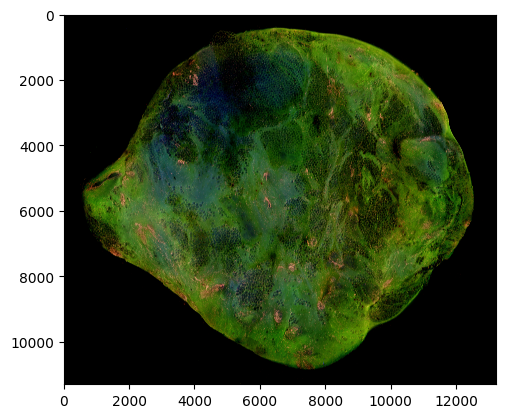

In [1119]:
plt.imshow(imageWSI); plt.show(); plt.close()

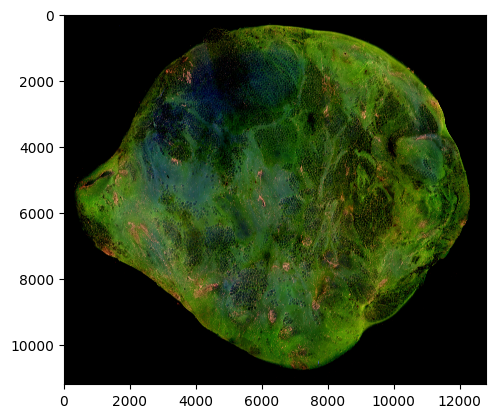

In [1097]:
plt.imshow(imageWSI); plt.show(); plt.close()

In [1092]:
cropLeft, cropRight, cropTop, cropBottom

(232, 13032, 88, 11288)

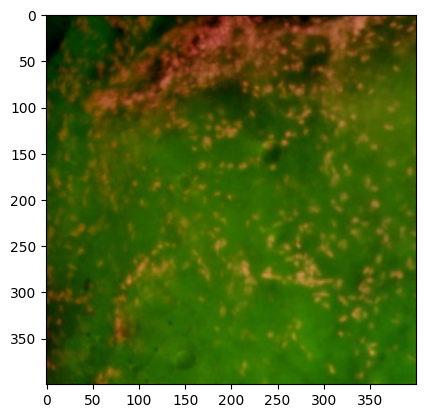

In [743]:
blockImage = cv2.cvtColor(cv2.imread(blockFilenames[0], cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
plt.imshow(blockImage)

In [ ]:
#If configured for WSI classification and RANDS data generation
if classifierWSI:

    #Load and process metadata for available samples
    sampleNamesAll_WSI, sampleLabelsAll_WSI = loadMetadata(file_WSI_labels)
    sampleFilenamesAll = [dir_WSI_inputs + sampleNamesAll_WSI[sampleIndex] + '.jpg' for sampleIndex in range(0, len(sampleNamesAll_WSI))]
    
    #Either split WSI into or load filenames for previously generated blocks 
    #Original work resized WSI before splitting into blocks, which potentially introduced inconsistent artifacting from altering the native aspect ratio
    if overwrite_WSI_blocks:

        #Extract uniform, non-overlapping blocks from each WSI; could probably parallelize this if given time to do so
        blockNamesAll_WSI, blockSampleNamesAll_WSI, blockFilenamesAll_WSI = [], [], []
        for filename in tqdm(sampleFilenamesAll, desc='WSI Block Extraction', leave=True, ascii=asciiFlag):

            #Extract base sample name
            sampleName = os.path.basename(filename).split('.jpg')[0]

            #Load WSI image
            imageWSI = cv2.cvtColor(cv2.imread(filename, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)



            #Split the WSI into blocks and flatten
            imageWSI = imageWSI.reshape(numBlocksRow, blockSize, numBlocksCol, blockSize, imageWSI.shape[2]).swapaxes(1,2)
            imageWSI = imageWSI.reshape(-1, imageWSI.shape[2], imageWSI.shape[3], imageWSI.shape[4])

            #Setup directory to store blocks
            dir_WSI_sample_blocks = dir_WSI_blocks + 'S' + sampleName + os.path.sep
            if not os.path.exists(dir_WSI_sample_blocks): os.makedirs(dir_WSI_sample_blocks)
            
            #Generate names and filenames for each block 
            blockNames_WSI, blockSampleNames_WSI, blockFilenames_WSI = [], [], []
            for rowNum in range(0, numBlocksRow):
                for colNum in range(0, numBlocksCol):
                    blockName = sampleName+'_'+str(rowNum)+'_'+str(colNum)
                    blockNames_WSI.append(blockName)
                    blockSampleNames_WSI.append(sampleName)
                    blockFilenames_WSI.append(dir_WSI_sample_blocks+'PS'+blockName+'.tif')
            
            blockNamesAll_WSI += blockNames_WSI
            blockSampleNamesAll_WSI += blockSampleNames_WSI
            blockFilenamesAll_WSI += blockFilenames_WSI
            
            #Store blocks to disk
            for index in range(0, len(blockFilenames_WSI)): exportImage(blockFilenames_WSI[index], imageWSI[index])
        
        #Clean the last WSI from RAM
        del imageWSI
        cleanup()
        
        #Save names and filenames to disk; relies on original filename ordering for re-assembling blocks during visualization
        blockSampleNamesAll_WSI = np.asarray(blockSampleNamesAll_WSI)
        blockFilenamesAll_WSI = np.asarray(blockFilenamesAll_WSI)
        np.save(dir_WSI_blocks + 'blockNamesAll_WSI', blockNamesAll_WSI)
        np.save(dir_WSI_blocks + 'blockSampleNamesAll_WSI', blockSampleNamesAll_WSI)
        np.save(dir_WSI_blocks + 'blockFilenamesAll_WSI', blockFilenamesAll_WSI)
        
    else: 
        blockNamesAll_WSI = np.load(dir_WSI_blocks + 'blockNamesAll_WSI.npy', allow_pickle=True)
        blockSampleNamesAll_WSI = np.load(dir_WSI_blocks + 'blockSampleNamesAll_WSI.npy', allow_pickle=True)
        blockFilenamesAll_WSI = np.load(dir_WSI_blocks + 'blockFilenamesAll_WSI.npy', allow_pickle=True)

    #Prepare classifier
    modelClassifier_WSI = Classifier(blockFilenamesAll_WSI, blockNamesAll_WSI, blockSampleNamesAll_WSI, sampleNamesAll_WSI)
    
    #Compute block features
    modelClassifier_WSI.computeFeatures(dir_WSI_features, overwrite_WSI_features)

    #Compute saliency maps for the blocks
    dirList_saliencyMaps_WSI = [dir_WSI_salicencyMaps, dir_WSI_preparedWSI, dir_WSI_assembled_saliencyMaps, dir_WSI_assembled_overlaid]
    if fusionMode_WSI: modelClassifier_WSI.computeSalicencyMaps(dirList_saliencyMaps_WSI, overwrite_WSI_saliencyMaps, fusionModeGlobal_WSI, visualize_WSI_saliencyMaps, maintainAspectRatio_WSI)
    

In [ ]:
 
            #For each of the blocks generate and/or store directory locations to save visualizations
            if visualize_saliencyMaps:
                dir_salicencyMapAll = []
                for sampleName in self.blockSampleNamesAll: 
                    
                    #Create base sample directory
                    dir_salicencyMap = dir_salicencyMaps + 'S' + sampleName + os.path.sep
                    if not os.path.exists(dir_salicencyMap): os.makedirs(dir_salicencyMap)
                    
                    #Create sub-directory for the saliency maps
                    dir_salicencyMap = dir_salicencyMap + 'SALIENCY_MAPS' + os.path.sep
                    if not os.path.exists(dir_salicencyMap): os.makedirs(dir_salicencyMap)
                    dir_salicencyMapAll.append(dir_salicencyMap)
            
            #Compute confidence weights for each block
            self.blockWeightsAll = []
            if visualize_saliencyMaps: self.filename_saliencyMapAll = []
            for batchNum, data in tqdm(enumerate(self.blockDataloader), total=self.numBlockData, desc='Weight Computation', leave=True, ascii=asciiFlag):
                
                #Generate saliency maps for each block
                blockSaliencyMaps = model_GradCamPlusPlus(input_tensor=data, targets=None)
                
                #For current GradCamPlusPlus implementation, must manually clear internal copy of the outputs from GPU cache to prevent OOM
                del model_GradCamPlusPlus.outputs 
                if len(gpus) > 0: torch.cuda.empty_cache()
                
                #Compute regional importance for each block as the average saliency map values
                blockImportances = np.mean(blockSaliencyMaps, axis=(1,2))
                
                #Threshold regional importance values by 0.25 to get block weights
                self.blockWeightsAll += list(np.where(blockImportances<0.25, 0, blockImportances))
                
                #Perform visualization of block saliency maps; remove alpha channel when saving
                if visualize_saliencyMaps:
                    blockIndices = np.arange(batchNum*batchsizeClassifier, (batchNum+1)*batchsizeClassifier)
                    for index in range(0, len(blockSaliencyMaps)):
                        blockIndex = blockIndices[index]
                        filename_saliencyMap = dir_salicencyMapAll[blockIndex] + 'saliencyMap_' + self.blockNamesAll[blockIndex] + '.tif'
                        exportImage(filename_saliencyMap, matplotlib.cm.jet(blockSaliencyMaps[index])[:,:,:-1].astype(np.float32))
                        self.filename_saliencyMapAll.append(filename_saliencyMap)
                        
            #Aggregate sample-specific visualizations into WSI, store per-block overlaid saliency maps, and compute a global saliency map similar to original work
            if visualize_saliencyMaps_WSI: 
                for sampleName in tqdm(self.sampleNamesAll, desc='WSI Visualization', leave=True, ascii=asciiFlag):

                    #Get block raw saliency map filenames specific to the sample
                    blockIndices = np.where(self.blockSampleNamesAll == sampleName)[0]
                    blockFilenames = np.asarray(self.filename_saliencyMapAll)[blockIndices]

                    #Assuming the original order and image dimensions haven't been manipulated, the last filename will have the dimension data required
                    numBlocksRow, numBlocksCol = np.asarray(os.path.basename(blockFilenames[-1]).split('.tif')[0].split('_')[-2:]).astype(int)+1
                    blockStichSize = cv2.cvtColor(cv2.imread(blockFilenames[-1], cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB).shape

                    #Load per-block saliency maps, reshape to original dimensions, and store to disk
                    overlay = np.empty((numBlocksRow, numBlocksCol, blockStichSize[0], blockStichSize[1], blockStichSize[2]), dtype=np.float32)
                    for filename in blockFilenames:
                        rowNum, colNum = np.asarray(os.path.basename(filename).split('.tif')[0].split('_')[-2:]).astype(int)
                        overlay[rowNum, colNum] = cv2.cvtColor(cv2.imread(filename, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
                    overlay = overlay.swapaxes(1,2)
                    overlay = overlay.reshape(overlay.shape[0]*overlay.shape[1], overlay.shape[2]*overlay.shape[3], overlay.shape[4])
                    exportImage(dir_WSI_assembled_saliencyMaps+'saliencyMap_'+sampleName+'.tif', overlay)

                    #Load the processed sample image
                    imageWSI = cv2.cvtColor(cv2.imread(dir_WSI_preparedWSI + 'S' + sampleName + '.tif', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
                    
                    #Resize/rescale the WSI to match the overlay (staying consistent with existing data processing), then save it to disk
                    transform = generateTransform(overlay.shape[:2], True, False)
                    overlaid = np.moveaxis(transform(np.moveaxis(imageWSI, -1, 0)).numpy(), 0, -1)
                    if overlayGray: overlaid = np.expand_dims(cv2.cvtColor(overlaid, cv2.COLOR_RGB2GRAY), -1)
                    overlaid = show_cam_on_image(overlaid, overlay, use_rgb=True, colormap=cv2.COLORMAP_JET, image_weight=1.0-overlayWeight)
                    exportImage(dir_WSI_assembled_overlaid+'overlaid_'+sampleName+'.tif', overlaid)

                    #Split overlay back into blocks and flatten; doing this rather than saving per-block overlays provides global color consistency with the assembled result
                    overlaid = overlaid.reshape(numBlocksRow, blockStichSize[0], numBlocksCol, blockStichSize[1], overlaid.shape[2]).swapaxes(1,2)
                    overlaid = overlaid.reshape(-1, overlaid.shape[2], overlaid.shape[3], overlaid.shape[4])

                    #Create sub-directory for overlaid saliency maps
                    dir_salicencyMap_overlaid = dir_salicencyMaps + 'S' + sampleName + os.path.sep + 'OVERLAID' + os.path.sep
                    os.makedirs(dir_salicencyMap_overlaid)
                    
                    #Store per-block overlaid saliency maps to disk
                    for index in range(0, len(blockFilenames)): exportImage(dir_salicencyMap_overlaid + 'overlaid' + os.path.basename(blockFilenames[index]).split('saliencyMap')[1], overlaid[index])
                    
                    
                    
                    
                    
                    

In [ ]:
    #Classify extracted block features
    def predict(self, inputs, fusionMode, weights=None):
        
        #Compute the raw block predictions
        blockPredictions = self.model_XGBClassifier.predict(inputs.astype(np.float32))
        
        #If fusion mode is active, multiply the block predictions (using -1 for benign and +1 for malignant) by the matching weights; positive results are malignant
        if fusionMode: 
            blockPredictionsFusion = np.where(blockPredictions==0, -1, 1)*weights
            blockPredictionsFusion = np.where(blockPredictionsFusion>0, 1, 0)
            return blockPredictions.tolist(), blockPredictionsFusion.tolist()
        else: 
            return blockPredictions.tolist()
        
    #Perform cross-validation
    def crossValidation(self):
        
        #If block weights are available, then enable evauation of fusion mode
        if len(self.blockWeightsAll)>0: fusionMode = True
        else: fusionMode = False
        
        #Allocate samples to folds for cross validation
        if type(manualFolds) != list: folds = [array.tolist() for array in np.array_split(np.random.permutation(self.sampleNamesAll), manualFolds)]
        else: folds = manualFolds
        numFolds = len(folds)

        #Split block features into specified folds, keeping track of originating indices and matched labels
        foldsIndices, foldsFeatures, foldsLabels, foldsWeights, foldsSampleNames, foldsBlockNames = [], [], [], [], [], []
        for fold in folds:
            blockIndices = np.concatenate([np.where(self.blockSampleNamesAll == sampleName)[0] for sampleName in fold])
            foldsIndices.append(blockIndices)
            foldsFeatures.append(list(self.blockFeaturesAll[blockIndices]))
            foldsLabels.append(list(self.blockLabelsAll[blockIndices]))
            if fusionMode: foldsWeights.append(list(self.blockWeightsAll[blockIndices]))
            foldsSampleNames.append(list(self.blockSampleNamesAll[blockIndices]))
            foldsBlockNames.append(list(self.blockNamesAll[blockIndices]))

        #Collapse indices, labels, and sample names for later (correct/matched ordered) evaluation of the fold data
        blockIndices = np.concatenate(foldsIndices)
        blockLabels = np.concatenate(foldsLabels)
        blockSampleNames = np.concatenate(foldsSampleNames)
        blockNames = np.concatenate(foldsBlockNames)

        #Check class distribution between the folds
        #print('B\t M \t Total')
        #for foldNum in range(0, numFolds):
        #    print(np.sum(np.array(foldsLabels[foldNum]) == 0),'\t', np.sum(np.array(foldsLabels[foldNum]) == 1), '\t', len(foldsLabels[foldNum]))

        #Perform training/testing among the folds, storing test results for later evaluation
        blockPredictions, blockPredictionsFusion = [], []
        for foldNum in tqdm(range(0, numFolds), desc='Block Classification', leave=True, ascii=asciiFlag):
            
            #Train on all folds except the one specified
            self.train(np.concatenate(foldsFeatures[:foldNum]+foldsFeatures[foldNum+1:]), np.concatenate(foldsLabels[:foldNum]+foldsLabels[foldNum+1:]))
            
            #Classify blocks in the specified, remaining fold
            if fusionMode: 
                foldPredictions, foldPredictionsFusion = self.predict(np.asarray(foldsFeatures[foldNum]), fusionMode, np.asarray(foldsWeights[foldNum]))
                blockPredictionsFusion += foldPredictionsFusion
            else:
                foldPredictions = self.predict(np.asarray(foldsFeatures[foldNum]), fusionMode)
            blockPredictions += foldPredictions
            
            #Clear the XGBClassifier model
            del self.model_XGBClassifier
            if len(gpus) > 0: torch.cuda.empty_cache() 
            
        #Convert lists of predictions to arrays
        blockPredictions = np.asarray(blockPredictions)
        blockPredictionsFusion = np.asarray(blockPredictionsFusion)
        
        #Sort data into natural order before output
        indexOrder = natsort.index_natsorted(blockNames)
        blockNames = blockNames[indexOrder]
        blockSampleNames = blockSampleNames[indexOrder]
        blockLabels = blockLabels[indexOrder]
        blockPredictions = blockPredictions[indexOrder]
        if fusionMode: blockPredictionsFusion = blockPredictionsFusion[indexOrder]
        
        #Save results to disk
        dataPrintout, dataPrintoutNames = [blockNames, blockLabels, blockPredictions], ['Names', 'Labels', 'Raw Predictions']
        if fusionMode: 
            dataPrintout.append(blockPredictionsFusion)
            dataPrintoutNames.append('Fusion Predictions')
        dataPrintout = pd.DataFrame(dataPrintout).transpose()
        dataPrintout.columns=dataPrintoutNames
        dataPrintout.to_csv(dir_blocks_results + 'predictions_blocks.csv', index=False)
        
        #Evaluate per-block results
        computeClassificationMetrics(blockLabels, blockPredictions, dir_blocks_results+'results_Blocks_Initial')
        if fusionMode: computeClassificationMetrics(blockLabels, blockPredictionsFusion, dir_blocks_results+'results_Blocks_Fusion')
    
        #Merge per-block results to obtain results for each WSI
        sampleNames = np.unique(blockSampleNames)
        sampleLabels, samplePredictions, samplePredictionsFusion = [], [], []
        for sampleName in sampleNames:

            #Find indices of samplename in sampleNames
            sampleIndices = np.where(blockSampleNames == sampleName)[0]

            #Determine if the number of malignant block predictions exceeds the configured threshold
            sampleLabels.append((np.mean(blockLabels[sampleIndices]) >= thresholdWSI)*1)
            samplePredictions.append((np.mean(blockPredictions[sampleIndices]) >= thresholdWSI)*1)
            if fusionMode: samplePredictionsFusion.append((np.mean(blockPredictionsFusion[sampleIndices]) >= thresholdWSI)*1)

        #Convert list of WSI labels/predictions to arrays
        sampleLabels = np.asarray(sampleLabels)
        samplePredictions = np.asarray(samplePredictions)
        samplePredictionsFusion = np.asarray(samplePredictionsFusion)
        
        #Sort data into natural order before output
        indexOrder = natsort.index_natsorted(sampleNames)
        sampleNames = sampleNames[indexOrder]
        sampleLabels = sampleLabels[indexOrder]
        samplePredictions = samplePredictions[indexOrder]
        if fusionMode: samplePredictionsFusion = samplePredictionsFusion[indexOrder]

        #Save results to disk
        dataPrintout, dataPrintoutNames = [sampleNames, sampleLabels, samplePredictions], ['Names', 'Labels', 'Raw Predictions']
        if fusionMode: 
            dataPrintout.append(samplePredictionsFusion)
            dataPrintoutNames.append('Fusion Predictions')
        dataPrintout = pd.DataFrame(dataPrintout).transpose()
        dataPrintout.columns=dataPrintoutNames
        dataPrintout.to_csv(dir_blocks_results + 'predictions_WSI.csv', index=False)
        
        #Evaluate original WSI results
        computeClassificationMetrics(sampleLabels, samplePredictions, dir_blocks_results+'results_WSI_Initial')
        if fusionMode: computeClassificationMetrics(sampleLabels, samplePredictionsFusion, dir_blocks_results+'results_WSI_Fusion')

    #Train on all available data and export models
    def exportClassifier(self):
        
        #Setup, train, save, and clear the XGBClassifier model
        self.train(self.blockFeaturesAll, self.blockLabelsAll)
        
        #Register converter for XGBClassifier
        update_registered_converter(XGBClassifier, "XGBoostXGBClassifier", calculate_linear_classifier_output_shapes, convert_xgboost, options={"nocl": [True, False], "zipmap": [True, False, "columns"]},)
        
        #Convert classifier to onnx format and save to disk
        model_onnx_XGBClassifier = to_onnx(modelClassifier_blocks.model_XGBClassifier, modelClassifier_blocks.blockFeaturesAll.astype(np.float32), target_opset={"": skl2onnx.__max_supported_opset__, "ai.onnx.ml": 3})
        with open(dir_results_models + 'model_XGBClassifier.onnx', 'wb') as f:f.write(model_onnx_XGBClassifier.SerializeToString())
        
        del self.model_XGBClassifier
        if len(gpus) > 0: torch.cuda.empty_cache() 
        
    #Load a pretrained model
    def loadClassifier(self):
        self.model_XGBClassifier = onnxruntime.InferenceSession(dir_results_models + 'model_XGBClassifier.onnx', providers = [('CUDAExecutionProvider', {"device_id": gpus[-1]}), 'CPUExecutionProvider'])
        self.model_XGBClassifier.predict = lambda inputs: session.run(None, {'X': inputs})[0]
    

In [ ]:
#If configured for WSI classification and RANDS data generation
if classifierWSI:

    #Load and process metadata for available samples
    sampleNamesAll_WSI, sampleLabelsAll_WSI = loadMetadata(file_WSI_labels)
    sampleFilenamesAll = [dir_WSI_inputs + sampleNamesAll_WSI[sampleIndex] + '.jpg' for sampleIndex in range(0, len(sampleNamesAll_WSI))]
    
    #Either split WSI into or load filenames for previously generated blocks 
    #Original work resized WSI before splitting into blocks, which potentially introduced inconsistent artifacting from altering the native aspect ratio
    if overwrite_WSI_blocks:

        #Extract uniform, non-overlapping blocks from each WSI; could probably parallelize this if given time to do so
        blockNamesAll_WSI, blockSampleNamesAll_WSI, blockFilenamesAll_WSI = [], [], []
        for filename in tqdm(sampleFilenamesAll, desc='WSI Block Extraction', leave=True, ascii=asciiFlag):

            #Extract base sample name
            sampleName = os.path.basename(filename).split('.jpg')[0]

            #Load WSI image
            imageWSI = cv2.cvtColor(cv2.imread(filename, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

            #Equalize image brightness with historgram equalization in YUV space and extract foreground with Otsu; no improvement, leaving for reference
            #y, cr, cb = cv2.split(cv2.cvtColor(imageWSI, cv2.COLOR_RGB2YCrCb))
            #imageWSI = cv2.cvtColor(cv2.merge((cv2.equalizeHist(y), cr, cb)), cv2.COLOR_YCR_CB2RGB)
            #mask = cv2.threshold(cv2.cvtColor(imageWSI, cv2.COLOR_RGB2GRAY),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
            
            #Crop image to the largest foreground area
            mask = cv2.threshold(cv2.cvtColor(imageWSI, cv2.COLOR_RGB2GRAY),0,255,cv2.THRESH_BINARY)[1]
            contour = max(cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(contour) 
            imageWSI = copy.deepcopy(imageWSI)[y:y+h, x:x+w]

            #Pad the image as needed (as symmetrially as possible) for an even division by the specified block size; compute numBlocks per row/column
            padHeight = (int(np.ceil(imageWSI.shape[0]/blockSize))*blockSize)-imageWSI.shape[0]
            padWidth = (int(np.ceil(imageWSI.shape[1]/blockSize))*blockSize)-imageWSI.shape[1]
            padTop, padLeft = padHeight//2, padWidth//2
            padBottom, padRight = padTop+(padHeight%2), padLeft+(padWidth%2)
            imageWSI = np.pad(imageWSI, ((padTop, padBottom), (padLeft, padRight), (0, 0)))
            numBlocksRow, numBlocksCol = imageWSI.shape[0]//blockSize, imageWSI.shape[1]//blockSize

            #Save processed WSI for ease of later visualization
            exportImage(dir_WSI_preparedWSI + 'S' + sampleName + '.tif', imageWSI)

            #Split the WSI into blocks and flatten
            imageWSI = imageWSI.reshape(numBlocksCol, blockSize, numBlocksCol, blockSize, imageWSI.shape[2]).swapaxes(1,2)
            imageWSI = imageWSI.reshape(-1, imageWSI.shape[2], imageWSI.shape[3], imageWSI.shape[4])

            #Setup directory to store blocks
            dir_WSI_sample_blocks = dir_WSI_blocks + 'S' + sampleName + os.path.sep
            if not os.path.exists(dir_WSI_sample_blocks): os.makedirs(dir_WSI_sample_blocks)
            
            #Generate names and filenames for each block 
            blockNames_WSI, blockSampleNames_WSI, blockFilenames_WSI = [], [], []
            for rowNum in range(0, numBlocksRow):
                for colNum in range(0, numBlocksCol):
                    blockName = sampleName+'_'+str(rowNum)+'_'+str(colNum)
                    blockNames_WSI.append(blockName)
                    blockSampleNames_WSI.append(sampleName)
                    blockFilenames_WSI.append(dir_WSI_sample_blocks+'PS'+blockName+'.tif')
            
            blockNamesAll_WSI += blockNames_WSI
            blockSampleNamesAll_WSI += blockSampleNames_WSI
            blockFilenamesAll_WSI += blockFilenames_WSI
            
            #Store blocks to disk
            for index in range(0, len(blockFilenames_WSI)): exportImage(blockFilenames_WSI[index], imageWSI[index])
        
        #Clean the last WSI from RAM
        del imageWSI
        cleanup()
        
        #Save names and filenames to disk; relies on original filename ordering for re-assembling blocks during visualization
        blockSampleNamesAll_WSI = np.asarray(blockSampleNamesAll_WSI)
        blockFilenamesAll_WSI = np.asarray(blockFilenamesAll_WSI)
        np.save(dir_WSI_blocks + 'blockNamesAll_WSI', blockNamesAll_WSI)
        np.save(dir_WSI_blocks + 'blockSampleNamesAll_WSI', blockSampleNamesAll_WSI)
        np.save(dir_WSI_blocks + 'blockFilenamesAll_WSI', blockFilenamesAll_WSI)
        
    else: 
        blockNamesAll_WSI = np.load(dir_WSI_blocks + 'blockNamesAll_WSI.npy', allow_pickle=True)
        blockSampleNamesAll_WSI = np.load(dir_WSI_blocks + 'blockSampleNamesAll_WSI.npy', allow_pickle=True)
        blockFilenamesAll_WSI = np.load(dir_WSI_blocks + 'blockFilenamesAll_WSI.npy', allow_pickle=True)

    #Prepare classifier
    modelClassifier_WSI = Classifier(blockFilenamesAll_WSI, blockNamesAll_WSI, blockSampleNamesAll_WSI, sampleNamesAll_WSI)
    
    #Compute block features
    modelClassifier_WSI.computeFeatures(dir_WSI_features, overwrite_WSI_features)

    #Compute saliency maps for the blocks
    dirList_saliencyMaps_WSI = [dir_WSI_salicencyMaps, dir_WSI_preparedWSI, dir_WSI_assembled_saliencyMaps, dir_WSI_assembled_overlaid]
    if fusionMode_WSI: modelClassifier_WSI.computeSalicencyMaps(dirList_saliencyMaps_WSI, overwrite_WSI_saliencyMaps, fusionModeGlobal_WSI, visualize_WSI_saliencyMaps, maintainAspectRatio_WSI)
    